# Imperfect HWP retardance and fast axis simulation - no meas or matrix noise

Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.95831470e-03 8.75012487e-04]
Normalized inverted_s_in: [1.00000000e+00 9.9583147

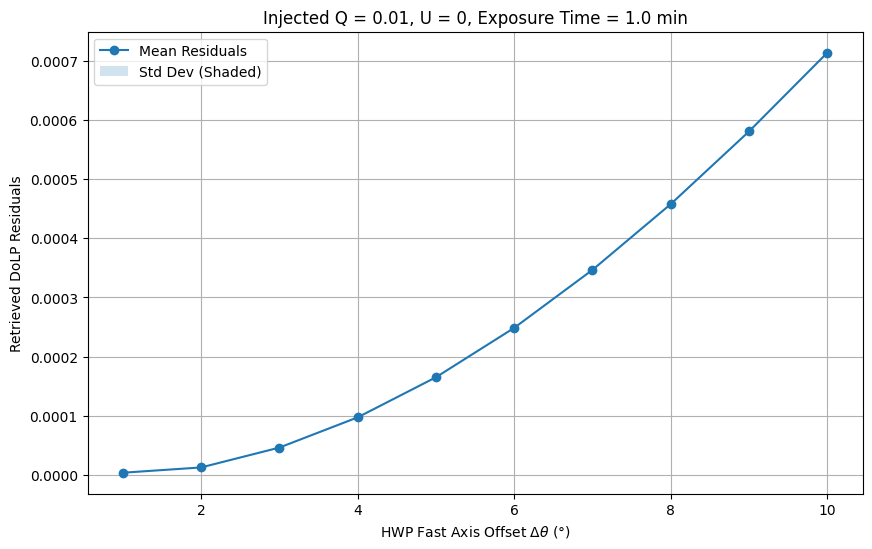

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 100

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
noise_percentage = 0  # Intensity noise
matrix_noise = 0  # Fixed matrix noise (1%)

# Varying HWP fast axis offset angles in degrees
delta_HWP_ang_values = np.arange(1, 11, 1)  # From 1 to 10 degrees
delta_HWP = 0.5
HWP_noise = 0  # Example noise for HWP retardance
num_trials = 50  # Number of trials per offset angle

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over HWP fast axis offset angles
    for delta_HWP_ang in delta_HWP_ang_values:
        residuals = []

        # Perform multiple trials for each offset angle
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                delta_HWP=delta_HWP,
                delta_HWP_ang=delta_HWP_ang,
                noise_percentage=noise_percentage,
                include_V=False,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps=num_samples,
                matrix_noise_type=matrix_noise_type,
                HWP_noise=HWP_noise,
                normalize_s_out = True
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
            
            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this offset angle
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(delta_HWP_ang_values, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(delta_HWP_ang_values, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"HWP Fast Axis Offset $\Delta \theta$ (°)")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        # f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Injected Q = {Q_injected}, U = {U_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()

In [2]:
import os
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'varying_HWP_fast_axis'
output_dir = "/home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, notebook_name + ".txt")

with open(output_path, "w") as f:
    f.write("delta_HWP_ang, mean_residual, std_residual, target_name, target_ra, target_dec\n")
    for target in targets:
        for i, delta_HWP_ang in enumerate(delta_HWP_ang_values):
            f.write(f"{delta_HWP_ang}, {mean_residuals[i]:.8f}, {std_residuals[i]:.8f}, {target['name']}, {target['ra']}, {target['dec']}\n")
print(f"Saved summary data to {output_path}")

Saved summary data to /home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files/varying_HWP_fast_axis.txt


# Reading in Saved File

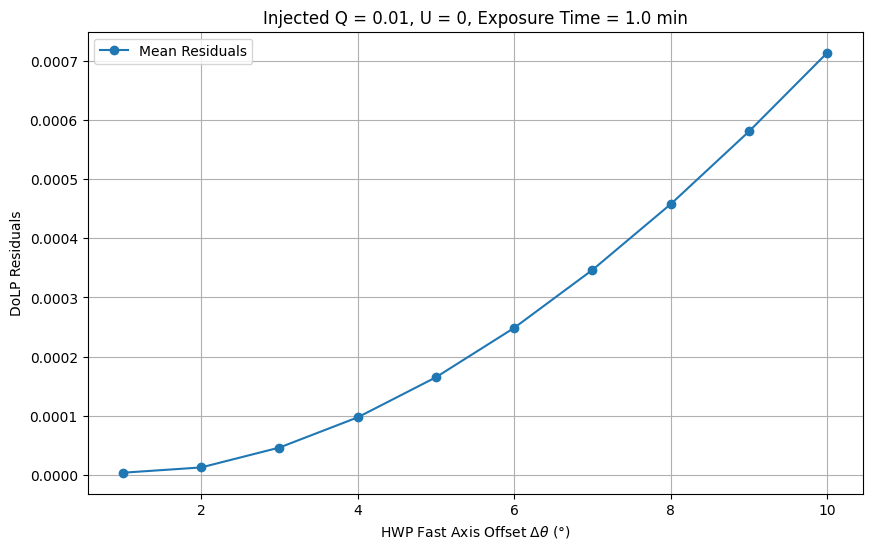

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
 ]

# Fixed parameters for plotting
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'varying_HWP_fast_axis'
output_dir = "/home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files"
txt_path = os.path.join(output_dir, notebook_name + ".txt")

# Read in the saved txt file
data = []
with open(txt_path, "r") as f:
    header = f.readline()  # skip header
    for line in f:
        parts = line.strip().split(",")
        delta_HWP_ang = float(parts[0])
        mean_residual = float(parts[1])
        std_residual = float(parts[2])
        target_name = parts[3].strip()
        target_ra = float(parts[4])
        target_dec = float(parts[5])
        data.append((delta_HWP_ang, mean_residual, std_residual, target_name, target_ra, target_dec))

# Convert to numpy array for easier plotting
data = np.array(data, dtype=object)

# Plot the results for each target
for target in targets:
    mask = data[:,3] == target['name']
    delta_HWP_ang_values = data[mask,0].astype(float)
    mean_residuals = data[mask,1].astype(float)
    std_residuals = data[mask,2].astype(float)

    plt.figure(figsize=(10, 6))
    plt.plot(delta_HWP_ang_values, mean_residuals, '-o', label=f"Mean Residuals")
    # plt.fill_between(delta_HWP_ang_values, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"HWP Fast Axis Offset $\Delta \theta$ (°)")
    plt.ylabel("DoLP Residuals")
    plt.title(
        # f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Injected Q = 0.01, U = 0, Exposure Time = 1.0 min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()